In [1]:
from selenium import webdriver
from itertools import count
from selenium.webdriver import Chrome
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import json
import time
from datetime import datetime
from multiprocessing.pool import Pool
from functools import partial

## Price tracking tool for an "Informed buyer"
Input: Basket of URLs  
Output: Dataframe consisting of prices of the item on Amazon, Target, and Walmart websites

In [2]:
def scraper(url_list, path, informed=True):
  
    #loop through entries in list of URLs
    for amazon_url in url_list:
        #empty dictionary to store output
        row_results = {}
        
        #find product on Amazon
        amazon_driver = Chrome(executable_path=path)
        amazon_driver.get(amazon_url)
        #wait for the webpage to load
        time.sleep(5)

        #grab product name from Amazon
        try:
            amazon_name = amazon_driver.find_element_by_xpath('//*[@id="productTitle"]').text
            row_results['amazon_name'] = amazon_name
        except:
            row_results['amazon_name'] = 'Item not found'
        
        #get Amazon price, if price is no longer available append 'Price not found'
        try:
            amazon_name = amazon_driver.find_element_by_xpath('//*[@id="priceblock_ourprice"]').text
            row_results['amazon_price'] = amazon_name
        except:
            row_results['amazon_price'] = 'Price not found'
        
        #get the ASIN
        if len(amazon_url.split('/')) == 5:
            asin = amazon_url.split('/')[4]
        else:
            asin = amazon_url.split('/')[5]
        amazon_driver.quit()
                
        #if UPC for a specific asin has already been looked up do not look up
        if asin in ASIN_dict:
            upc_id = ASIN_dict[asin]
        
        #otherwise get UPC from ASIN
        #note: can only look up 10 items per hour
        else:
            print("Item not found in ASIN-UPC dictionary. \nLooking up the UPC.")
            upc_driver = Chrome(executable_path=path)
            upc_driver.get('https://www.synccentric.com/features/upc-asin/')
            box = upc_driver.find_element_by_id('scrollto')
            form = box.find_element_by_class_name('form-group')
            input = form.find_element_by_name('identifier')
            input.send_keys(asin)
            input.submit()
            #wait for the webpage to load
            time.sleep(10)
            id_list = upc_driver.find_element_by_class_name('col-sm-8').find_elements_by_tag_name('strong')
            upc_id = id_list[1].get_attribute('innerHTML')
            upc_driver.quit()
            #add the new asin --> upc to the dict
            ASIN_dict[asin] = upc_id
            with open('allusers.json','w') as b:
                b.write(json.dumps(ASIN_dict))
        #find product on Target
        target_driver = Chrome(executable_path=path)
        target_url = 'https://www.target.com/s?searchTerm=' + upc_id
        target_driver.get(target_url)
        #wait for the webpage to load
        time.sleep(5)
        
        #get Target name if the item is found on Target 
        try:
            target_name = target_driver.find_element_by_xpath('//*[@id="mainContainer"]/div[3]/div[2]/div/div[1]/div[3]/div/ul/li/div/div[2]/div/div/div/div[1]/div[1]/a').text
            row_results['target_name'] = target_name
        except:
            row_results['target_name'] = "Item not found"
        
        #get Target price if item was found on Target
        try:
            target_price = target_driver.find_element_by_xpath('//*[@id="mainContainer"]/div[3]/div[2]/div/div[1]/div[3]/div/ul/li/div/div[2]/div/div/div/div[2]/span').text
            row_results['target_price'] = target_price
        except:
            row_results['target_price'] = "Price not found"
 
        target_driver.quit()
    


        #find product on Walmart
        walmart_driver = Chrome(executable_path=path)
        walmart_url = 'https://www.walmart.com/search/?query=' + upc_id
        walmart_driver.get(walmart_url)
        
        names_prices = walmart_driver.find_elements_by_xpath("//div[contains(@class, 'tile-content Grid-col u-size-8-10-l list-description-wrapper')]")
        
        #get Walmart name and price if product was found on Walmart
        if len(names_prices) == 0:
            
            row_results['walmart_name'] = 'Item not found'
            row_results['walmart_price'] = 'Price not found'
        else:
            for i in names_prices:
                if 'Pack' not in i.text:
                    #if name of the product from Walmart has already been looked up do not scrape again
                    price_list = i.text.split('\n')
                    row_results['walmart_name'] = price_list[price_list.index('Product Title')+1]
                    row_results['walmart_price'] = price_list[price_list.index('Current Price')+1]
                    
        walmart_driver.quit()

        
        #save results at time of scrape        
        timeofscrape = {}
        timeofscrape['scraped_at'] = str(datetime.today())
        timeofscrape['item'] = row_results
        if informed==True:
            with open('price_monitor.json', 'a') as pm:
                pm.write(','+json.dumps(timeofscrape))
        elif informed==False:
            with open('price_scraper.json', 'a') as pm:
                pm.write(','+json.dumps(timeofscrape))            

## Price tracking tool for a "Window Shopper"
Input: a search string, a number of items and a low and high value for that product.  
    Note: input search term as a space seperated string only.  
Output: n items that match the price criteria for the item.

In [3]:
def find_top_n(search_term: str, n: int, low_price: float, high_price: float, min_reviews: int, min_rating: float):
    '''
    This function takes as input a search string, a number of items and a low and high value for that product.
    Note: input search term as a space seperated string only. 
    It returns the n items that match the price criteria for the item. 
    '''
    final_items = []
    updated_search = search_term.replace(' ', '+')
    for page_number in count(1):
        if len(final_items) == n:
            driver.close()
            return final_items
        if page_number >= 9:
            print('The query has gone through 8 pages of items, but only {} have matched the criteria. The query has halted and your basket will contain this many itenms, as there are not likely to be more matches'.format(len(final_items)))
            break
            driver.close()
        page = True
        driver = webdriver.Chrome(executable_path=path)
        search = driver.get('https://www.amazon.com/s?k={0}&page={1}&qid=1586809805&ref=sr_pg_3'.format(updated_search, page_number))
        while page:
            for i in count(0):
                item = driver.find_elements_by_css_selector('div[data-index="{}"]'.format(i))
                if len(item) == 0:
                    # go to next page and start iterator over?
                    page = False
                    break
                try:
                    price = item[0].find_element_by_class_name('a-price').text
                    final_price = float(price.replace('$',"").replace('\n', '.'))
                except:
                    final_price = 0
                asin = item[0].get_attribute('data-asin')
                if asin != '':    
                    if final_price >= low_price:
                        if final_price <= high_price:
                            reviews = item[0].find_elements_by_css_selector('span[aria-label]')
                            try:
                                rating = float(reviews[0].get_attribute('aria-label')[:3])
                            except:
                                rating = 0
                            try:
                                num_reviews = int(reviews[1].get_attribute('aria-label').replace(',',''))
                            except:
                                num_reviews = 0 
                            if num_reviews >= min_reviews:
                                if rating >= min_rating:
                                    url = 'https://www.amazon.com/dp/' + asin
                                    if url not in final_items:
                                        final_items.append(url)
                if len(final_items) == n:
                    driver.close()
                    return final_items
    return(final_items)

'''
Pooling to optimize runtime of the function
'''
def chunkify(lst, n):
    """builds generator for dividing input lst into n chunks"""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

### Defining inputs

In [9]:
path = '/usr/local/bin/chromedriver'
 
'''Informed Buyer'''
#basket of items as URL
with open('basket_list.json') as l:
  basket_list = json.load(l)
#basket of items as ASIN-UPC
with open('allusers.json') as f:
  ASIN_dict = json.load(f) 

# Main function

In [146]:
def price_scraper():
    buyer_type = input('Are you an Informed Buyer (I) or a Window Shopper (W)? ').strip().upper()
    '''Informed buyer'''
    if buyer_type == 'I':
        basket_type = input('Are you using a new list (N) or existing (E)? ').strip().upper()
        if basket_type == 'E':
            basket = basket_list
        elif basket_type == 'N':
            basket = []
            N = int(input('How many products would you like in your basket? '))
            for n in range(N):
                item = input('Paste Amazon links of the product you want to track and press Enter key when done ')
                if item == '':
                    print('Invalid input.')
                    return
                else:
                    basket.append(item)
        #run the scraper
        runtime = {}
        start = time.time()
        runtime['start_scrape'] = str(datetime.today())

        #for less than 4 items in basket, run regular scraper
        if len(basket)<4:
            scraper(basket,path,informed=True)
        #else, run pool
        else:
            # Due to the particulars of pooling, need to create a partial version of scraper with path defined
            scraper_partial = partial(scraper, path=path)
            chunked_basket = list(chunkify(basket, 4))
            with Pool(4) as p:
                p.map(scraper_partial, chunked_basket)

        end = time.time()
        runs = end - start
        runtime['runtime'] = str(runs)
        with open('runtime.json', 'a') as rt:
            json.dump(runtime, rt)
            
        # OUTPUT
        with open('price_monitor.json') as f:
            price_tracker = json.loads("[" + f.read() + "]")
        prices = []
        for p in price_tracker:
            price_dict = dict(p)
            scraped_at = price_dict['scraped_at']
            items = list(price_dict['item'].values())
            price = [scraped_at]+items
            prices.append(price)
        #create dataframe for entire result dataset
        price_df = pd.DataFrame(prices, columns=['scraped_at','amazon_name', 'amazon_price', 'target_name', \
                                                 'target_price', 'walmart_name', 'walmart_price'])
        #for each item in the basket
        n = len(basket)
        item_amzn = price_df['amazon_name'][-n:].unique()
        for idx in range(len(item_amzn)):
            title = item_amzn[idx]
            print(title)
            item_title = str(item_amzn[idx][:15])
            #create a dataframe with prices over time
            dfout = price_df[price_df['amazon_name'].str.contains(re.escape(item_title))]

            #check Amazon
            a = list(dfout['amazon_price'])
            if a[-1] <= min(a):
                if a[-1] == 'Price not found':
                    print('Unfortunately the item is not sold at Amazon')
                else:
                    print('Price is at its lowest at Amazon today at',a[-1])
            else:
                print('Please wait for a better deal at Amazon')
            #check Target
            t = list(dfout['target_price'])
            if t[-1] <= min(t):
                if t[-1] == 'Price not found':
                    print('Unfortunately the item is not sold at Target')
                else:
                    print('Price is at its lowest at Target today at',t[-1])
            else:
                print('Please wait for a better deal at Target')
            #check Walmart
            w = list(dfout['walmart_price'])
            if w[-1] <= min(w):
                if w[-1] == 'Price not found':
                    print('Unfortunately the item is not sold at Walmart')
                else:
                    print('Price is at its lowest at Walmart today at',w[-1])
            else:
                print('Please wait for a better deal at Walmart')

                
    ''' Window Shopper'''         
    elif buyer_type == 'W':
        print('Please provide some information to narrow your search: ')
        search_term = input('Enter a type of product you want to purchase and press Enter key when done: ')

        if search_term == '':
            print('Invalid input.')
            return

        else:
            n = int(input('Select number of pages you would like to see and press Enter key when done: '))
            low_price = float(input('Select lowest price and press Enter key when done: '))
            high_price = float(input('Select highest price and press Enter key when done:'))
            min_reviews = int(input('Select minimum number of reviews and press Enter key when done: '))
            min_rating = float(input('Select minimum rating and press Enter key when done: '))
            basket = find_top_n(search_term, n, low_price, high_price, min_reviews, min_rating)
        #run the scraper
        a = {"scraped_at": "date", "item": {"amazon_name": "Amazon name", "amazon_price": "Amazon price", \
                                            "target_name": "Target name", "target_price": "Target price", \
                                            "walmart_name": "Walmart name", "walmart_price": "Walmart price"}}
        with open('price_scraper.json', 'w') as pm:
            pm.write(json.dumps(a))
        #for less than 4 items in basket, run regular scraper
        if len(basket)<4:
            scraper(basket,path,informed=False)
        #else, run pool
        else:
            # Due to the particulars of pooling, we need to create a partial version of scraper that already has the path defined
            scraper_partial = partial(scraper, path=path, informed=False)
            chunked_basket = list(chunkify(basket, 4))
            with Pool(4) as p:
                p.map(scraper_partial, chunked_basket)
                
        # OUTPUT
        with open('price_scraper.json') as f:
            price_tracker = json.loads("[" + f.read() + "]")
        prices = []
        for p in price_tracker:
            price_dict = dict(p)
            scraped_at = price_dict['scraped_at']
            items = list(price_dict['item'].values())
            price = [scraped_at]+items
            prices.append(price)
        price_df = pd.DataFrame(prices, columns=['scraped_at','amazon_name', 'amazon_price', 'target_name', 'target_price', 'walmart_name', 'walmart_price'])
        price_df = price_df[1:]
        return price_df

### Test run for an Informed Buyer

In [148]:
price_scraper()

Are you an Informed Buyer (I) or a Window Shopper (W)? I
Are you using a new list (N) or existing (E)? N
How many products would you like in your basket? 2
Paste Amazon links of the product you want to track and press Enter key when done https://www.amazon.com/Bose-SoundLink-Portable-Long-Lasting-Bluetooth/dp/B06XCW4VFS/ref=sr_1_1?dchild=1&keywords=017817726016&qid=1587403350&sr=8-1
Paste Amazon links of the product you want to track and press Enter key when done https://www.amazon.com/Bose-Cancelling-Wireless-Bluetooth-Headphones/dp/B07Q9MJKBV/ref=sr_1_1?dchild=1&keywords=017817796163&qid=1587169795&sr=8-1
Bose SoundLink Revolve+ Portable and Long-Lasting Bluetooth 360 Speaker - Triple Black
Price is at its lowest at Amazon today at $299.00
Please wait for a better deal at Target
Price is at its lowest at Walmart today at $299.00
Bose Noise Cancelling Wireless Bluetooth Headphones 700, with Alexa Voice Control, Black
Price is at its lowest at Amazon today at $349.00
Please wait for a 

### Test run for a Window Shopper

In [13]:
price_scraper()

Are you an Informed Buyer (I) or a Window Shopper (W)? W
Please provide some information to narrow your search: 
Enter a type of product you want to purchase and press Enter key when done: air fryer
Select number of pages you would like to see and press Enter key when done: 10
Select lowest price and press Enter key when done: 40
Select highest price and press Enter key when done:120
Select minimum number of reviews and press Enter key when done: 400
Select minimum rating and press Enter key when done: 4.2
Item not found in ASIN-UPC dictionary. 
Looking up the UPC.
Item not found in ASIN-UPC dictionary. 
Looking up the UPC.
Item not found in ASIN-UPC dictionary. 
Looking up the UPC.
Item not found in ASIN-UPC dictionary. 
Looking up the UPC.


,scraped_at,amazon_name,amazon_price,target_name,target_price,walmart_name,walmart_price
1,2020-05-02 18:13:10.870256,"COSORI Air Fryer,Max XL 5.8 Quart,1700-Watt El...",$119.99,Item not found,Price not found,Cosori CP158-AF Air Fryer 5.8QT,$119.99
2,2020-05-02 18:13:33.662783,"Ninja AF101 Air Fryer that Cooks, Crisps and D...",$99.99,Item not found,Price not found,Item not found,Price not found
3,2020-05-02 18:13:36.446188,PowerXL Power AirFryer 5.3 Quart Black,$110.99,Item not found,Price not found,Item not found,Price not found
4,2020-05-02 18:13:43.410017,"Yedi Total Package Air Fryer XL, 5.8 Quart, De...",$109.95,Item not found,Price not found,Item not found,Price not found
5,2020-05-02 18:14:06.192502,GoWISE USA GW22731 1700-Watt 5.8-QT 8-in-1 Dig...,$73.41,Item not found,Price not found,GoWISE USA 5.5 Liter 8-in-1 Electric Air Fryer,$79.99
6,2020-05-02 18:14:11.156817,"Ultrean Air Fryer, 4.2 Quart (4 Liter) Electri...",$69.99,Item not found,Price not found,Item not found,Price not found
7,2020-05-02 18:14:29.501419,"OMORC Air Fryer, 6 Quart, 1800W Fast Large Hot...",$89.99,Item not found,Price not found,Item not found,Price not found
8,2020-05-02 18:14:30.445891,Dash DFAF455GBAQ01 Deluxe Electric Air Fryer +...,$79.99,Item not found,Price not found,Item not found,Price not found
9,2020-05-02 18:14:34.045812,GoWISE USA GW22956 7-Quart Electric Air Fryer ...,$98.80,Item not found,Price not found,GoWISE GW22956 7-Quart Electric Air Fryer with...,$97.99
10,2020-05-02 18:15:25.971209,Dash DCAF150GBGY02 Compact Air Fryer Oven Cook...,$46.99,Item not found,Price not found,Item not found,Price not found


### Sample output for Informed Buyer

<Figure size 432x288 with 0 Axes>

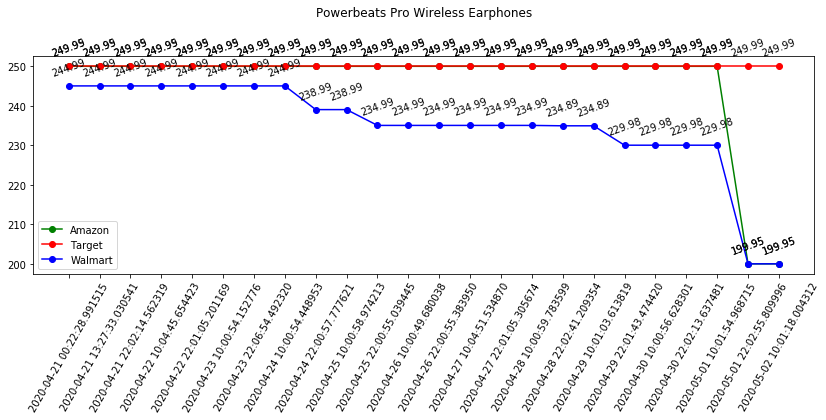

In [19]:
dfout = pric_df[pric_df['amazon_name'].str.contains('Powerbeats')]

a = list(dfout['amazon_price'])
aa = []
for i in range(0,len(a)):
    if a[i] == 'Price not found':
        try:
            a[i] = a[i-1]
            aa.append(float(a[i].replace("$","")))
        except:
            a[i] = 0
            aa.append(a[i])

    else:
        aa.append(float(a[i].replace("$","")))
        
t = list(dfout['target_price'])
tt = []
for i in range(0,len(t)):
    if t[i] == 'Price not found':
        try:
            t[i] = t[i-1]
            tt.append(float(t[i].replace("$","")))
        except:
            t[i] = 0
            tt.append(t[i])
        
    else:
        tt.append(float(t[i].replace("$","")))
        
w = list(dfout['walmart_price'])
ww = []
for i in range(0,len(w)):
    if w[i] == 'Price not found':
        w[i] = w[i-1]
        ww.append(float(w[i].replace("$","")))
    else:
        ww.append(float(w[i].replace("$","")))
if w[-1] <= min(w):
    print('cheapest',w[i])
else:
    print('wait')
        
        
ts = list(dfout['scraped_at'])


#Plotting the prices
plt.clf()

fig = plt.figure(figsize=(14,4))
ax = fig.add_subplot(111)
plt.plot(ts,aa,'go-',label='Amazon')
plt.plot(ts,tt,'ro-',label='Target')
plt.plot(ts,ww,'bo-',label = 'Walmart')
plt.xticks(rotation=60)
    
    
for x,y in zip(ts,aa):
    label = "{:.2f}".format(y)
    plt.annotate(label, (x,y), textcoords="offset points", xytext=(0,10), ha='center',rotation=20)
for x,y in zip(ts,tt):
    label = "{:.2f}".format(y)
    plt.annotate(label, (x,y), textcoords="offset points", xytext=(0,10), ha='center',rotation=20)
    
for x,y in zip(ts,ww):
    label = "{:.2f}".format(y)
    plt.annotate(label, (x,y), textcoords="offset points", xytext=(0,10), ha='center',rotation=20)
plt.legend(loc="lower left")
plt.title('Powerbeats Pro Wireless Earphones',pad=40)
plt.show()